In [69]:
import networkx as nx
from scipy.stats import qmc
from scipy.spatial import distance
import pandas as pd
import numpy as np
import random
from math import sqrt
import time
import matplotlib.pyplot as plt

In [70]:
# 1. Create graph, clones, add clones' profiles:

def create_graph(size_of_network, min_clone_edges, max_clone_edges):

    bounds = range(2, size_of_network + 1)

    # Create graph
    G = nx.Graph()
    elist = [(1,x) for x in bounds]
    G.add_edges_from(elist)

    # Create clones
    clone_list = list(bounds)

    def clon_tuple(i, aux):
        clone_lst = list()
        for j in aux:
            clone_lst.append(("c"+str(i), j))

        return clone_lst

    i = 1
    while clone_list:
        rnd = random.randint(min_clone_edges, max_clone_edges)
        aux = clone_list[:rnd]
        edge_list = clon_tuple(i, aux)
        G.add_edges_from(edge_list)

        del clone_list[:rnd]
        i += 1

    clones = [x for x in list(G.nodes) if str(x).startswith('c')]
    clones_profiles = [np.random.randint(2, size=21) for x in clones]

    return (G, clones_profiles)

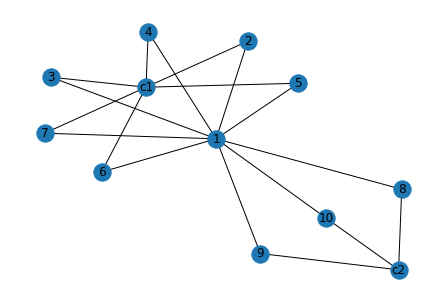

In [71]:
result = create_graph(10, 1, 10)
nx.draw(result[0], with_labels=True)

In [72]:
# 2. Create victim's profile, 

victims_profile = np.array([0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1])


In [73]:
# 3. Define mutation strategy

def mutate(candidate, min_clone_edges, max_clone_edges):

    graph, clones_profiles = candidate[0], candidate[1]

    chance = random.choice(['add_edge','del_edge','mutate_profile'])

    adj_matrix = nx.to_pandas_adjacency(graph)

    clones = [column for column in adj_matrix.columns if str(column).startswith('c')]
    clone_idx = random.choice(range(len(clones)))
    clone = clones[clone_idx]

    profile = clones_profiles[clone_idx]

    if chance == 'add_edge':
        idx = None
        while idx is None:
            
            aux = random.randint(min_clone_edges, max_clone_edges)
            if sum(adj_matrix.iloc[adj_matrix.columns.get_loc(clone)]) == max_clone_edges:
                chance = 'mutate_profile'
                break
            
            if adj_matrix.iloc[adj_matrix.columns.get_loc(clone), aux] != 1:
                idx = aux
                # first delete connection with other clone.
                for c in clones:
                    if adj_matrix.iloc[adj_matrix.columns.get_loc(c), idx] == 1:
                        adj_matrix.iat[adj_matrix.columns.get_loc(c), idx] = 0
                        adj_matrix.iat[idx, adj_matrix.columns.get_loc(c)] = 0
                # then assing the connection to this clone.
                adj_matrix.iat[adj_matrix.columns.get_loc(clone), idx] = 1
                adj_matrix.iat[idx, adj_matrix.columns.get_loc(clone)] = 1

    if chance == 'del_edge':
        idx = None
        i = 0
        while idx is None and i < max_clone_edges:
            
            i +=1
            
            aux = random.randint(min_clone_edges, max_clone_edges)
            if sum(adj_matrix.iloc[adj_matrix.columns.get_loc(clone)]) == min_clone_edges:
                chance = 'mutate_profile'
                break
            
            if adj_matrix.iloc[adj_matrix.columns.get_loc(clone), aux] != 0:
                idx = aux
                # first delete connection with other clone.
                adj_matrix.iat[adj_matrix.columns.get_loc(clone), idx] = 0
                adj_matrix.iat[idx, adj_matrix.columns.get_loc(clone)] = 0
                # then assing the connection to another random clone.
                rnd_clone = None
                while rnd_clone is None:
                    aux = random.choice(clones)
                    if aux is not clone and adj_matrix.iloc[adj_matrix.columns.get_loc(aux), idx] == 0:
                        rnd_clone = aux
                        adj_matrix.iat[adj_matrix.columns.get_loc(rnd_clone), idx] = 1
                        adj_matrix.iat[idx, adj_matrix.columns.get_loc(rnd_clone)] = 1

    elif chance == 'mutate_profile':
        
        new_profile = None
        while new_profile is None:
            
            aux = np.random.randint(2, size=21)
            if profile is not aux:
                new_profile = aux
                clones_profiles[clone_idx] = new_profile

    A = adj_matrix.values
    mutated_graph = nx.from_numpy_array(A)
    nx.relabel.relabel_nodes(mutated_graph, dict(enumerate(adj_matrix.columns)), copy=True)

    return (mutated_graph, clones_profiles)


In [74]:
# 4. Define evaluation

def evaluation(candidate, victims_profile, centrality):

    graph, clones_profiles = candidate[0], candidate[1]
    adj_m = nx.to_pandas_adjacency(graph)
    clones = [column for column in adj_m.columns if str(column).startswith('c')]

    def sim_profile(a_pc,a_pv,f_pc,f_pv):

        def sim_attributes(pc,pv):

            sa = 0
            for i, j in zip(pv, pc):
                if i != 0 and i == j:
                    sa +=1

            ac = abs(sum(pc))
            av = abs(sum(pv))
            
            return sa/sqrt(ac*av)

        def sim_network(pc,pv):

            mff = 0
            for i, j in zip(pv, pc):
                if i != 0 and i == j:
                    mff +=1

            fc = abs(sum(pc))
            fv = abs(sum(pv))
            
            return abs(mff)/sqrt(fc*fv)
  
        s_att = sim_attributes(a_pc,a_pv)
        s_ff = sim_network(f_pc,f_pv)

        return sqrt((s_att**2)*(s_ff**2))

    profile_sim = list()
    for profile, clone in zip(clones_profiles, clones):
        sim = sim_profile(profile, victims_profile, adj_m.iloc[adj_m.columns.get_loc(clone)],adj_m.iloc[adj_m.columns.get_loc(1)])
        profile_sim.append(sim)

    s1 = pd.Series({k:v for k,v in nx.degree_centrality(graph).items() if str(k).startswith('c')}, name='Degree', dtype='float64')
    s1 = s1.apply(lambda x:(x-s1.min())/(s1.max()-s1.min()))

    s2 = pd.Series({k:v for k,v in centrality(graph).items() if str(k).startswith('c')}, name=centrality, dtype='float64')
    s2 = s2.apply(lambda x:(x-s2.min())/(s2.max()-s2.min()))

    s3 = pd.Series(profile_sim, index=clones, name='Profile_sim', dtype='float64')
    s3 = s3.apply(lambda x:(x-s3.min())/(s3.max()-s3.min()))
    
    df = pd.concat([s1, s2, s3], axis=1)

    return df

In [75]:
# 5. star-discrepancy evaluation

def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [79]:
# 6. evolution strategy (mu, lambda) algorithm

def es_plus(size_of_network, min_clone_edges, max_clone_edges, victims_profile, objective, n_iter, mu, lam, centrality):

  # size_of_network: size of victim's network including the victim.
  # min/max_clone_edges: min/max number of edges that a clone can have.

  best, best_eval, start = None, 1e+10, time.time()

	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = create_graph(size_of_network, min_clone_edges, max_clone_edges)            # create initial graph
    population.append(candidate)                                                           # add to population

  # perform the search
  for epoch in range(n_iter):
    print('iter_n: ', epoch)
    # evaluate the fitness for the population
    scores = [objective(evaluation(candidate,victims_profile,centrality)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval, niter = population[i], scores[i], epoch
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
      # keep the parent
      offspring.append(population[i])

      # create offspring for parent
      for _ in range(n_children):
        child = mutate(population[i],min_clone_edges, max_clone_edges)
        offspring.append(child)

    # replace population with children
    population = offspring
  
  end = time.time()
  total_time = end - start
  return [niter, best, best_eval, total_time]

In [80]:
niter, best, best_eval, total_time = es_plus(5000,1,150,victims_profile,objective,1000,1,20,nx.pagerank)

iter_n:  0
0, Best eval: = 0.09060
iter_n:  1
iter_n:  2
iter_n:  3
3, Best eval: = 0.08839
iter_n:  4
iter_n:  5
5, Best eval: = 0.08716
iter_n:  6
6, Best eval: = 0.08701
iter_n:  7
7, Best eval: = 0.08572
iter_n:  8
8, Best eval: = 0.08451
iter_n:  9
iter_n:  10
iter_n:  11
iter_n:  12
iter_n:  13
iter_n:  14
iter_n:  15
iter_n:  16
iter_n:  17
iter_n:  18
iter_n:  19
iter_n:  20
iter_n:  21
iter_n:  22
iter_n:  23
iter_n:  24
iter_n:  25
iter_n:  26
iter_n:  27
iter_n:  28
iter_n:  29
iter_n:  30
iter_n:  31
iter_n:  32
iter_n:  33
iter_n:  34
iter_n:  35
iter_n:  36
iter_n:  37
iter_n:  38
iter_n:  39
iter_n:  40
iter_n:  41
iter_n:  42
iter_n:  43
iter_n:  44
iter_n:  45
iter_n:  46
iter_n:  47
iter_n:  48
iter_n:  49
49, Best eval: = 0.07425
iter_n:  50
50, Best eval: = 0.07316
iter_n:  51
iter_n:  52
iter_n:  53
iter_n:  54
54, Best eval: = 0.06183
iter_n:  55
iter_n:  56
iter_n:  57
iter_n:  58
iter_n:  59
iter_n:  60
iter_n:  61
iter_n:  62
iter_n:  63
iter_n:  64
iter_n:  65

In [81]:
evaluation(best, victims_profile, nx.pagerank)

,Degree,<function pagerank at 0x10bbc69d0>,Profile_sim
c1,0.699301,0.699301,0.832156
c2,0.762238,0.762238,0.238606
c3,0.328671,0.328671,0.231363
c4,0.839161,0.839161,0.819736
c5,0.909091,0.909091,0.527104
c6,0.251748,0.251748,0.000000
c7,0.804196,0.804196,0.694471
c8,0.930070,0.930070,0.342258
c9,0.811189,0.811189,0.410817
c10,0.321678,0.321678,0.282094


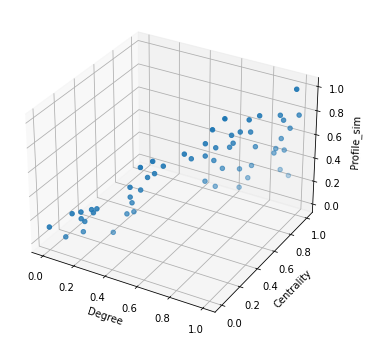

In [90]:
ev = evaluation(best, victims_profile, nx.pagerank)
ev.columns.values[1] = "pagerank"

fig, ax = plt.subplots(1,1, figsize=(10,6), subplot_kw=dict(projection='3d'))
ax.scatter3D(ev['Degree'],ev['pagerank'],ev['Profile_sim'])
# ax.plot([0, 1], # x
#         [0, 1], # y
#         [0.2, 0.2], color='red') # z 
ax.set_xlabel('Degree')
ax.set_ylabel('Centrality')
ax.set_zlabel('Profile_sim')
#ax.set_title(f'Star-discrepancy score: {objective(ev):.3f}')
plt.show()

In [83]:
ev

,Degree,pagerank,Profile_sim
c1,0.699301,0.699301,0.832156
c2,0.762238,0.762238,0.238606
c3,0.328671,0.328671,0.231363
c4,0.839161,0.839161,0.819736
c5,0.909091,0.909091,0.527104
c6,0.251748,0.251748,0.000000
c7,0.804196,0.804196,0.694471
c8,0.930070,0.930070,0.342258
c9,0.811189,0.811189,0.410817
c10,0.321678,0.321678,0.282094


In [84]:
len(list(best[0].nodes))

5056

In [85]:
colormap = []
colormap.append('red')
for i in range(2,5001):
  colormap.append('blue')

for i in range(len([x for x in list(best[0].nodes) if str(x).startswith('c')])):
  colormap.append('green')

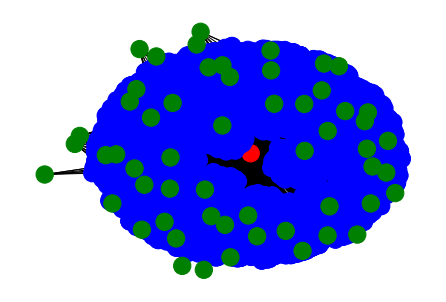

In [86]:
nx.draw(best[0], node_color=colormap)

In [ ]:
1/0

In [ ]:
size_of_network, min_clone_edges, max_clone_edges = 5000, 1, 150

graph, clones_profiles = create_graph(size_of_network,min_clone_edges, max_clone_edges)

chance = random.choice(['add_edge','del_edge','mutate_profile'])

print(chance)

adj_matrix = nx.to_pandas_adjacency(graph)

clones = [column for column in adj_matrix.columns if str(column).startswith('c')]
clone_idx = random.choice(range(len(clones)))
clone = clones[clone_idx]
profile = clones_profiles[clone_idx]



add_edge


In [ ]:
clones[0]

'c1'

In [ ]:
chance = 'add_edge'

for i in range(5):
    if chance == 'add_edge':
        print(chance)
        idx = None
        while idx is None:
            aux = random.randint(min_clone_edges, max_clone_edges)
            if sum(adj_matrix.iloc[adj_matrix.columns.get_loc(clone)]) == max_clone_edges:
                chance = 'mutate_profile'
                print(chance)
                break
            
            if adj_matrix.iloc[adj_matrix.columns.get_loc(clone), aux] != 1:
                idx = aux
                # first delete connection with other clone.
                for c in clones:
                    if adj_matrix.iloc[adj_matrix.columns.get_loc(c), idx] == 1:
                        adj_matrix.iat[adj_matrix.columns.get_loc(c), idx] = 0
                        adj_matrix.iat[idx, adj_matrix.columns.get_loc(c)] = 0
                # then assing the connection to this clone.
                adj_matrix.iat[adj_matrix.columns.get_loc(clone), idx] = 1
                adj_matrix.iat[idx, adj_matrix.columns.get_loc(clone)] = 1

    elif chance == 'mutate_profile':
        
        new_profile = None
        while new_profile is None:
            print(chance)
            aux = np.random.randint(2, size=21)
            if profile is not aux:
                new_profile = aux
                clones_profiles[clone_idx] = new_profile

    print(clones_profiles[2])
#adj_matrix

add_edge
mutate_profile
[1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0]
mutate_profile
[1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0]
mutate_profile
[0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0]
mutate_profile
[0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1]
mutate_profile
[0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1]


In [ ]:
clone

'c3'

In [ ]:
sum(adj_matrix.loc['c3'])

150.0

In [ ]:
chance = 'del_edge'

for i in range(100):

    if chance == 'del_edge':
        print(chance)
        idx = None
        while idx is None:
            aux = random.randint(min_clone_edges, max_clone_edges)
            if sum(adj_matrix.iloc[adj_matrix.columns.get_loc(clone)]) == min_clone_edges:
                chance = 'mutate_profile'
                print(chance)
                break
            
            if adj_matrix.iloc[adj_matrix.columns.get_loc(clone), aux] != 0:
                idx = aux
                # first delete connection with other clone.
                adj_matrix.iat[adj_matrix.columns.get_loc(clone), idx] = 0
                adj_matrix.iat[idx, adj_matrix.columns.get_loc(clone)] = 0
                # then assing the connection to another random clone.
                rnd_clone = None
                while rnd_clone is None:
                    aux = random.choice(clones)
                    if aux is not clone and adj_matrix.iloc[adj_matrix.columns.get_loc(aux), idx] == 0:
                        rnd_clone = aux
                        adj_matrix.iat[adj_matrix.columns.get_loc(rnd_clone), idx] = 1
                        adj_matrix.iat[idx, adj_matrix.columns.get_loc(rnd_clone)] = 1

adj_matrix

del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
del_edge
mutate_profile


,1,2,3,4,5,6,7,8,9,10,...,c58,c59,c60,c61,c62,c63,c64,c65,c66,c67
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sum(adj_matrix.loc['c3'])

1.0